<a href="https://colab.research.google.com/github/Mo-kw/Car-Plate-Detection-with-YOLOv11/blob/main/Car_Plate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/car-plate-detection


In [ ]:
cp -r /kaggle/input/car-plate-detection /content/


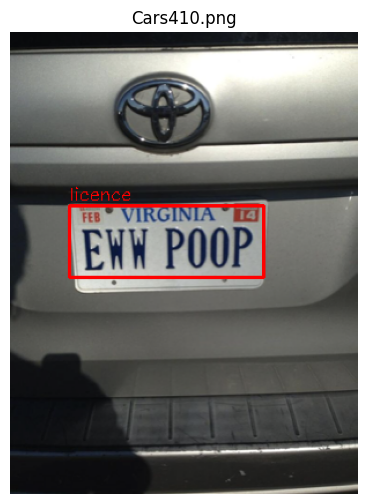

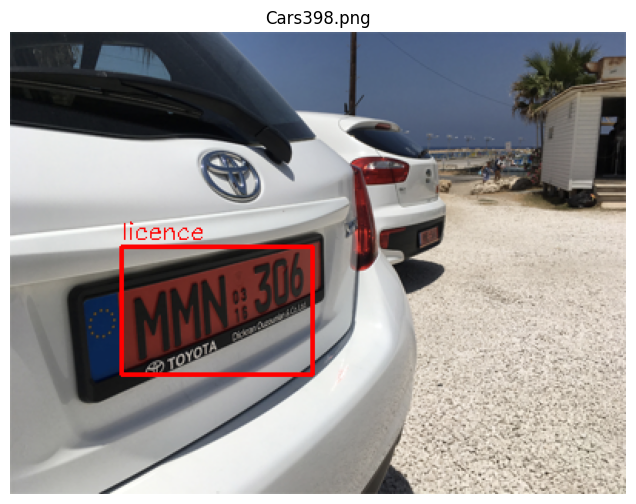

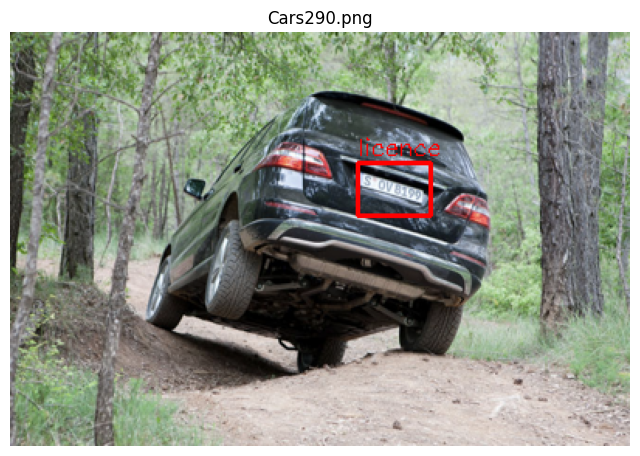

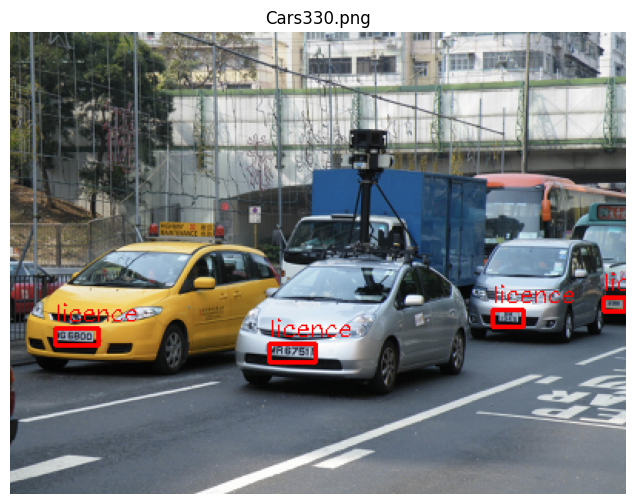

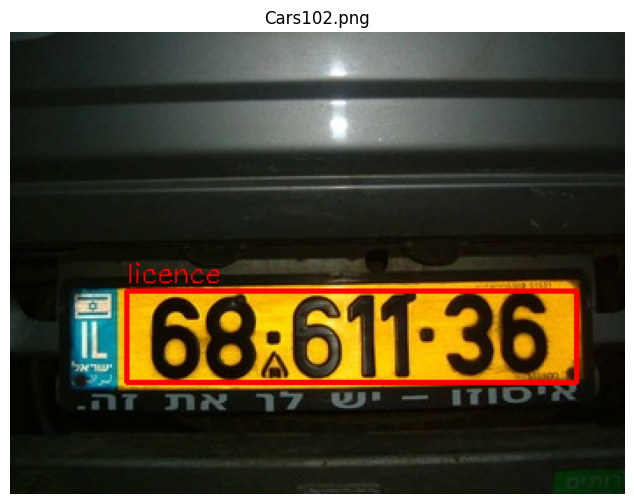

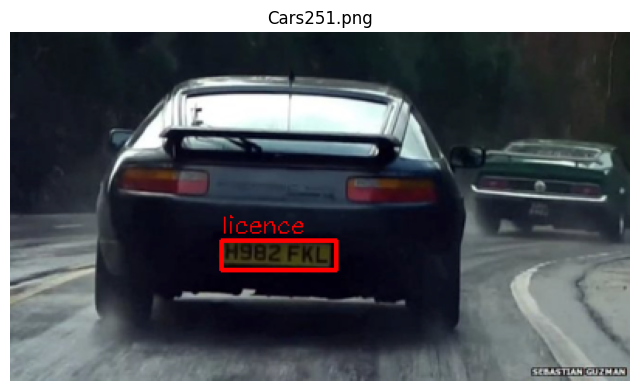

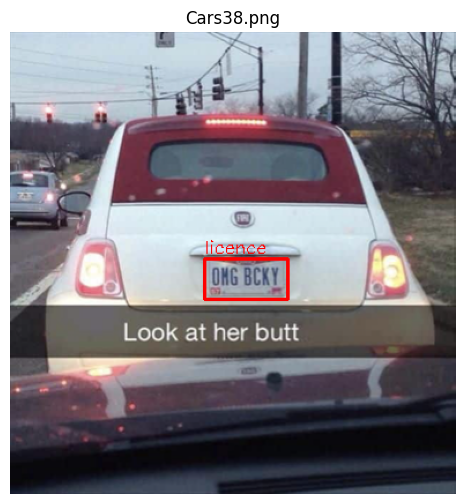

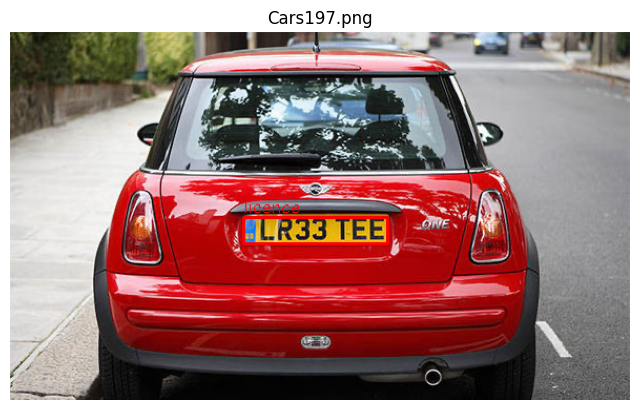

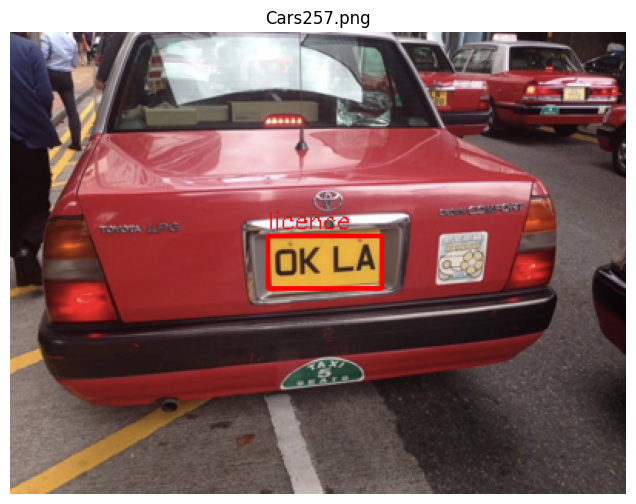

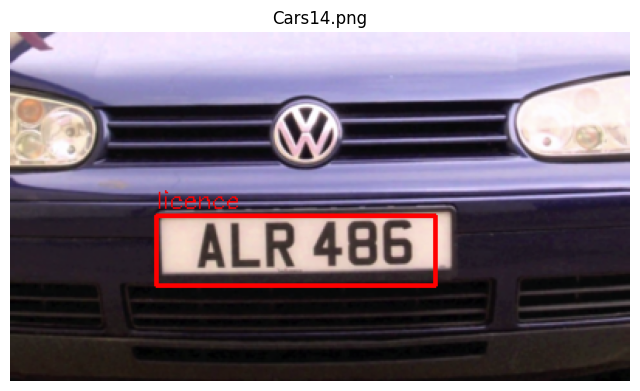

In [ ]:
import os
import cv2
import random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Paths
dataset_path = '/content/car-plate-detection'
images_path = os.path.join(dataset_path, 'images')
annotations_path = os.path.join(dataset_path, 'annotations')

# Get all image filenames
image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)
sample_images = image_files[:10]

def draw_boxes(image_path, annotation_path):
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Parse XML
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        # Draw rectangle and label
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(image, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image

# Show 10 random images with bounding boxes
for img_file in sample_images:
    img_path = os.path.join(images_path, img_file)
    xml_path = os.path.join(annotations_path, os.path.splitext(img_file)[0] + '.xml')

    if os.path.exists(xml_path):
        img_with_boxes = draw_boxes(img_path, xml_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img_with_boxes)
        plt.axis('off')
        plt.title(img_file)
        plt.show()
    else:
        print(f"Annotation not found for {img_file}")


In [ ]:
import os

# Set dataset paths
dataset_path = 'car-plate-detection'
images_path = os.path.join(dataset_path, 'images')
annotations_path = os.path.join(dataset_path, 'annotations')

# Count files
num_images = len([f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))])
num_annotations = len([f for f in os.listdir(annotations_path) if os.path.isfile(os.path.join(annotations_path, f))])

print(f"Number of image files: {num_images}")
print(f"Number of annotation files: {num_annotations}")


Number of image files: 433
Number of annotation files: 433


In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

# === Configuration ===
dataset_path = '/content/car-plate-detection'
images_dir = os.path.join(dataset_path, 'images')
annotations_dir = os.path.join(dataset_path, 'annotations')
classes = ['licence']


# YOLOv11 structure
output_dir = '/content/yolo_dataset'
images_train = os.path.join(output_dir, 'images/train')
images_val = os.path.join(output_dir, 'images/val')
labels_train = os.path.join(output_dir, 'labels/train')
labels_val = os.path.join(output_dir, 'labels/val')

# Create folders
for d in [images_train, images_val, labels_train, labels_val]:
    os.makedirs(d, exist_ok=True)

# === Function to convert VOC to YOLO format ===
def convert_annotation(xml_file, label_output_path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_w = int(root.find("size/width").text)
    image_h = int(root.find("size/height").text)

    yolo_lines = []

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name not in classes:
            continue
        class_id = classes.index(class_name)
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Convert to YOLO format
        x_center = (xmin + xmax) / 2 / image_w
        y_center = (ymin + ymax) / 2 / image_h
        width = (xmax - xmin) / image_w
        height = (ymax - ymin) / image_h

        yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    with open(label_output_path, "w") as f:
        f.write("\n".join(yolo_lines))


# === Split dataset ===
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# === Move and convert files ===
def process_files(file_list, img_dest, label_dest):
    for img_file in file_list:
        base_name = os.path.splitext(img_file)[0]
        xml_path = os.path.join(annotations_dir, base_name + '.xml')
        if not os.path.exists(xml_path):
            continue

        # Copy image
        shutil.copy(os.path.join(images_dir, img_file), os.path.join(img_dest, img_file))

        # Convert annotation
        convert_annotation(xml_path, os.path.join(label_dest, base_name + '.txt'))

# Process training and validation files
process_files(train_files, images_train, labels_train)
process_files(val_files, images_val, labels_val)

print("Dataset organized")


In [ ]:
yaml_str = """
path: /content/yolo_dataset
train: images/train
val: images/val
names:
  0: plate
"""

with open('/content/car_plate.yaml', 'w') as f:
    f.write(yaml_str.strip())

print("YAML config file created.")


YAML config file created.


In [ ]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLOv11 model
model = YOLO('yolo11n.pt')

# Train with your dataset and config yaml
model.train(data='/content/car_plate.yaml', epochs=50, imgsz=640)


Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/car_plate.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /content/yolo_dataset/labels/train... 346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 346/346 [00:00<00:00, 880.00it/s]

train: New cache created: /content/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 726.7±67.8 MB/s, size: 462.4 KB)


val: Scanning /content/yolo_dataset/labels/val... 87 images, 0 backgrounds, 0 corrupt: 100%|██████████| 87/87 [00:00<00:00, 359.21it/s]

val: New cache created: /content/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.44G      1.535      3.337      1.336         22        640: 100%|██████████| 22/22 [00:09<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all         87         97    0.00333      0.897      0.546        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.57G       1.43      2.163      1.234         15        640: 100%|██████████| 22/22 [00:08<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         87         97      0.487      0.206      0.212     0.0939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.57G      1.491        2.1      1.277         23        640: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         87         97      0.229      0.165      0.119     0.0564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.57G      1.504      1.955       1.27         19        640: 100%|██████████| 22/22 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         87         97        0.8      0.289      0.469      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.57G      1.476      1.709      1.252         22        640: 100%|██████████| 22/22 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         87         97      0.719      0.155      0.406      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.57G      1.506      1.636      1.268         23        640: 100%|██████████| 22/22 [00:08<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         87         97      0.359      0.433      0.271      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.57G      1.479       1.53       1.25         17        640: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

                   all         87         97       0.53      0.485      0.509      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.57G       1.44      1.421       1.23         19        640: 100%|██████████| 22/22 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         87         97      0.425      0.289      0.267      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.57G      1.473      1.386       1.25         25        640: 100%|██████████| 22/22 [00:07<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         87         97      0.712      0.737       0.75      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.57G      1.423      1.297      1.245         14        640: 100%|██████████| 22/22 [00:08<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         87         97      0.795      0.753      0.769      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.57G       1.35       1.19      1.212         19        640: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         87         97      0.799      0.658      0.735      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.57G      1.404      1.171      1.214         21        640: 100%|██████████| 22/22 [00:08<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         87         97      0.843      0.742      0.842       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.57G      1.387       1.16      1.182         18        640: 100%|██████████| 22/22 [00:07<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]

                   all         87         97      0.875      0.795      0.871      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.57G      1.399      1.106      1.206         16        640: 100%|██████████| 22/22 [00:06<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         87         97      0.862      0.708        0.8      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.57G      1.338      1.086      1.177         20        640: 100%|██████████| 22/22 [00:08<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         87         97      0.838      0.763      0.795      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.57G      1.339      1.043      1.195         22        640: 100%|██████████| 22/22 [00:08<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         87         97       0.86      0.763      0.849       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.57G      1.291     0.9717      1.141         16        640: 100%|██████████| 22/22 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]

                   all         87         97      0.751      0.811      0.845      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.57G      1.299     0.9595       1.16         18        640: 100%|██████████| 22/22 [00:07<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         87         97       0.83      0.754      0.819      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.57G       1.32     0.9658      1.191         19        640: 100%|██████████| 22/22 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         87         97      0.771      0.691       0.76      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.57G       1.27     0.9132       1.13         24        640: 100%|██████████| 22/22 [00:08<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         87         97      0.928      0.793      0.881      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.57G      1.315     0.9471       1.17         20        640: 100%|██████████| 22/22 [00:07<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         87         97      0.887       0.81      0.886       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.57G      1.279     0.9085      1.147         20        640: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         87         97       0.82      0.846      0.906      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.57G      1.259     0.9029      1.154         29        640: 100%|██████████| 22/22 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]

                   all         87         97       0.89      0.837      0.908       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.57G      1.246     0.8742      1.115         15        640: 100%|██████████| 22/22 [00:09<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         87         97      0.887      0.809      0.862      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.57G      1.195     0.8232      1.123         28        640: 100%|██████████| 22/22 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

                   all         87         97      0.951      0.814      0.921      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.57G      1.236      0.825      1.127         23        640: 100%|██████████| 22/22 [00:07<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         87         97      0.933      0.876      0.936      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.57G      1.213     0.8064      1.107         24        640: 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         87         97      0.945      0.845      0.934      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.57G      1.239      0.827      1.106         23        640: 100%|██████████| 22/22 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

                   all         87         97      0.936      0.814      0.891      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.57G        1.2     0.8055      1.115         27        640: 100%|██████████| 22/22 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]

                   all         87         97      0.918      0.808      0.881      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.57G       1.18     0.7838      1.095         19        640: 100%|██████████| 22/22 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         87         97      0.848      0.866      0.904      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.57G      1.216     0.8171      1.112         11        640: 100%|██████████| 22/22 [00:07<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         87         97      0.862      0.835      0.891      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.57G      1.198     0.7797      1.125         20        640: 100%|██████████| 22/22 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         87         97      0.836      0.887      0.902      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.57G       1.18     0.7538      1.092         22        640: 100%|██████████| 22/22 [00:08<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         87         97       0.83      0.906      0.904      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.57G      1.086     0.7051      1.076         22        640: 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         87         97      0.875      0.825      0.904      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.57G      1.138      0.712      1.079         19        640: 100%|██████████| 22/22 [00:06<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

                   all         87         97      0.907      0.856      0.914      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.57G      1.126     0.7104      1.079         30        640: 100%|██████████| 22/22 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]

                   all         87         97      0.869      0.845      0.901      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.57G      1.127     0.6875      1.058         14        640: 100%|██████████| 22/22 [00:08<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         87         97      0.904      0.876      0.912      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.57G      1.181     0.7122      1.123         23        640: 100%|██████████| 22/22 [00:07<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all         87         97      0.936      0.897      0.946      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.57G      1.136     0.6885      1.073         21        640: 100%|██████████| 22/22 [00:06<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         87         97      0.879      0.907      0.914      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.57G      1.095       0.68      1.055         22        640: 100%|██████████| 22/22 [00:08<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         87         97      0.902      0.876      0.912      0.503


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.57G      1.082     0.6922       1.06         10        640: 100%|██████████| 22/22 [00:09<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         87         97      0.912      0.856      0.884      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.57G      1.067     0.6507      1.047         10        640: 100%|██████████| 22/22 [00:08<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         87         97      0.904      0.874       0.89      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.57G      1.085      0.661      1.075         10        640: 100%|██████████| 22/22 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         87         97       0.94      0.866      0.913      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.57G      1.035     0.6247      1.036         10        640: 100%|██████████| 22/22 [00:07<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         87         97      0.972      0.866      0.947      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.57G      1.031     0.6166      1.031         11        640: 100%|██████████| 22/22 [00:07<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         87         97      0.949      0.856      0.917      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.57G      1.034      0.612      1.035         10        640: 100%|██████████| 22/22 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

                   all         87         97      0.921      0.836      0.909      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.57G     0.9926     0.5949      1.021         10        640: 100%|██████████| 22/22 [00:06<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         87         97       0.93      0.824      0.912      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.57G      0.969     0.5708      1.015         11        640: 100%|██████████| 22/22 [00:08<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]

                   all         87         97       0.93      0.845      0.924      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.57G     0.9769     0.5732      1.025         10        640: 100%|██████████| 22/22 [00:07<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         87         97      0.905      0.876      0.924      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.57G     0.9743     0.5788       1.01         10        640: 100%|██████████| 22/22 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

                   all         87         97      0.907      0.866      0.916      0.507



50 epochs completed in 0.139 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


                   all         87         97      0.932      0.876      0.936      0.521
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79d416a7ee10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


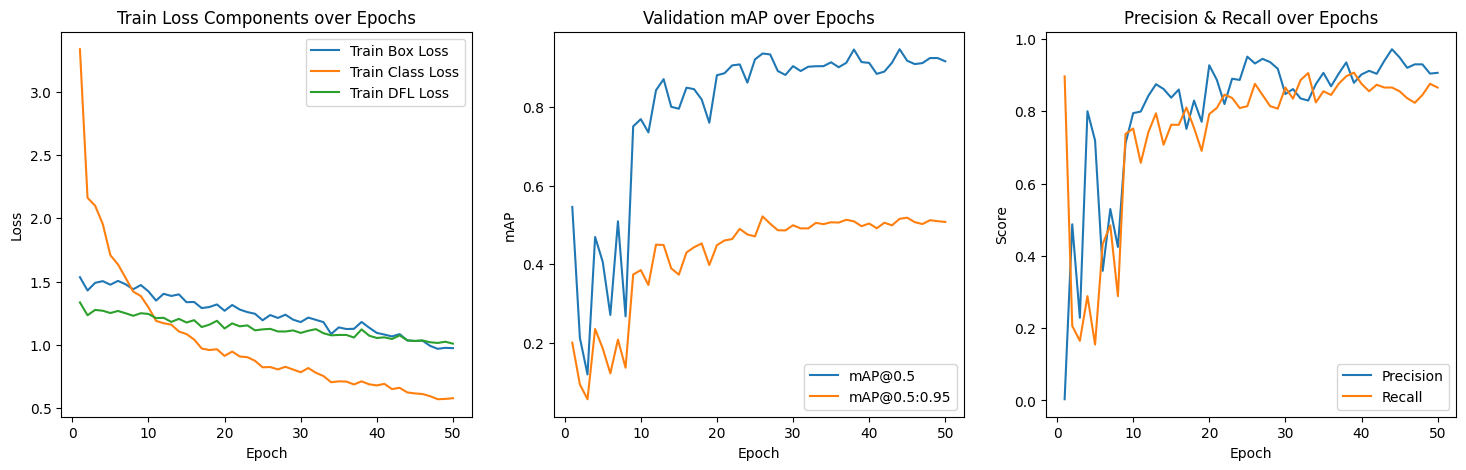

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = '/content/runs/detect/train/results.csv'
df = pd.read_csv(log_path)

# Show columns available
print(df.columns)

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
plt.plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Components over Epochs')
plt.legend()

plt.subplot(1,3,2)
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Validation mAP over Epochs')
plt.legend()

plt.subplot(1,3,3)
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision & Recall over Epochs')
plt.legend()

plt.show()



image 1/1 /content/yolo_dataset/images/val/Cars6.png: 480x640 1 plate, 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/yolo_dataset/images/val/Cars170.png: 480x640 1 plate, 8.4ms
Speed: 2.1ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/yolo_dataset/images/val/Cars83.png: 480x640 1 plate, 8.4ms
Speed: 2.0ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/yolo_dataset/images/val/Cars44.png: 480x640 2 plates, 12.2ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/yolo_dataset/images/val/Cars124.png: 448x640 4 plates, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/yolo_dataset/images/val/Cars81.png: 480x640 2 plates, 9.9ms
Speed: 1.8ms preprocess, 9.9ms inference

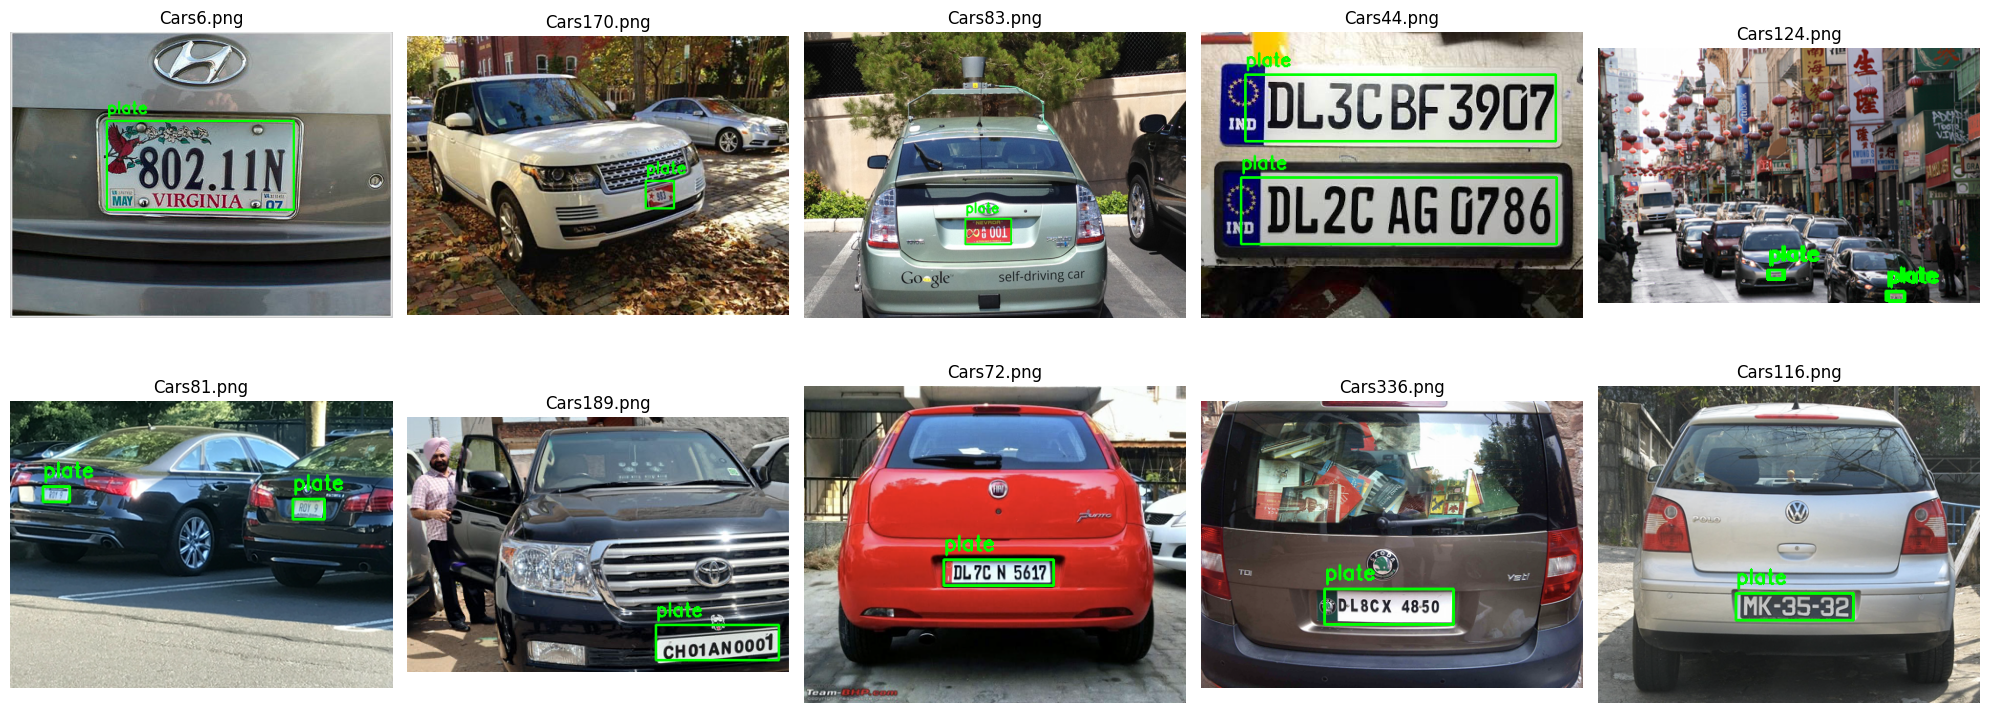

In [ ]:
from ultralytics import YOLO
import os
import random
import matplotlib.pyplot as plt
import cv2
import math

# Load best.pt model
model = YOLO('/content/runs/detect/train/weights/best.pt')

val_images_dir = '/content/yolo_dataset/images/val'
val_images = [f for f in os.listdir(val_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

random_images = random.sample(val_images, 10)

# Define grid size (e.g., 2 rows x 5 columns)
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(20, 8))
axs = axs.flatten()

for i, img_file in enumerate(random_images):
    img_path = os.path.join(val_images_dir, img_file)
    results = model.predict(img_path)
    result = results[0]
    img = result.orig_img.copy()  # BGR

    for box, cls in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy()):
        x1, y1, x2, y2 = box.astype(int)
        label = result.names[int(cls)]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axs[i].imshow(img_rgb)
    axs[i].axis('off')
    axs[i].set_title(img_file)

# Hide any unused subplots (if less than rows*cols)
for j in range(i+1, rows*cols):
    axs[j].axis('off')

plt.tight_layout()
plt.show()
